# Capstone #1 - Wine Data

The data used in this notebook was cleaned from the larger wine review dataset. During the cleaning step, countries with fewer than 500 reviews were omitted. For preliminary cleaning steps, see winedata-cleaning.ipynb

In [64]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import zscore
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier


# Sections:

# 1. Initial Analysis with Entire Cleaned Dataset
# 2. French Wines
# 3. Italian Wines
# 4. California Wines
# 5. Conclusion


In [2]:
winedata = pd.read_csv("cleaned_wine_data.csv")
winedata = winedata.drop('Unnamed: 0', 1)
winedata.head()

,country,description,designation,points,price,region,sub_region,taster_name,taster_twitter_handle,title,variety,winery
0,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
1,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
2,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
3,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
4,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


# Initial Analysis with Entire Cleaned Dataset

The variables that present the greatest interest in the wine review dataset are **'points', 'country', and 'price'**. The follow visualizations show how these variables are represented in the data as a whole.

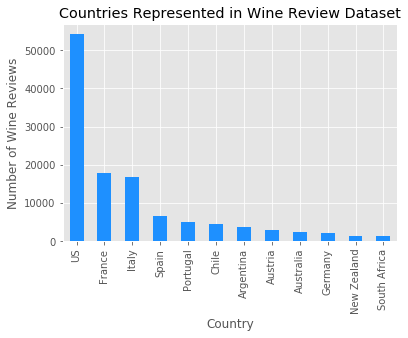

In [3]:
winedata['country'].value_counts().plot(kind='bar', color='dodgerblue')
plt.title('Countries Represented in Wine Review Dataset')
plt.ylabel('Number of Wine Reviews')
plt.xlabel('Country')

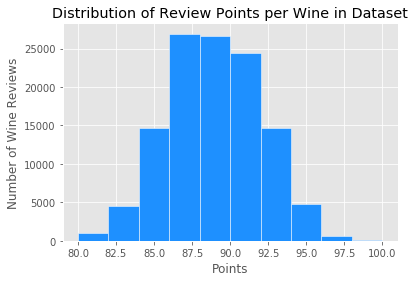

In [4]:
winedata['points'].hist(color='dodgerblue', ec='white')
plt.title('Distribution of Review Points per Wine in Dataset')
plt.ylabel('Number of Wine Reviews')
plt.xlabel('Points')

Max price: 3300.0
Mix price: 4.0


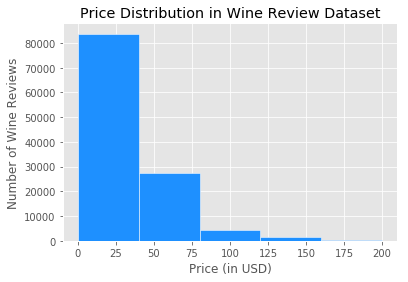

In [5]:
winedata['price'].hist(color='dodgerblue', ec='white', bins = 5, range= (0, 200))
plt.title('Price Distribution in Wine Review Dataset')
plt.ylabel('Number of Wine Reviews')
plt.xlabel('Price (in USD)')
print ("Max price: " + str(winedata['price'].max()))
print ("Mix price: " + str(winedata['price'].min()))

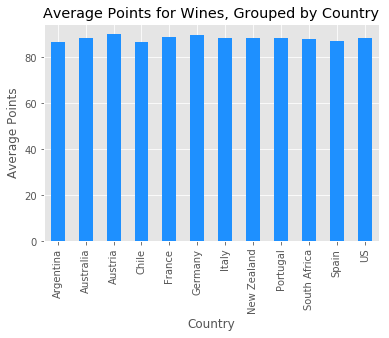

In [6]:
avg_pts_per_country = winedata.groupby('country')['points'].mean()
avg_pts_per_country.plot(kind ='bar', color = 'dodgerblue')
plt.title('Average Points for Wines, Grouped by Country')
plt.ylabel('Average Points')
plt.xlabel('Country')

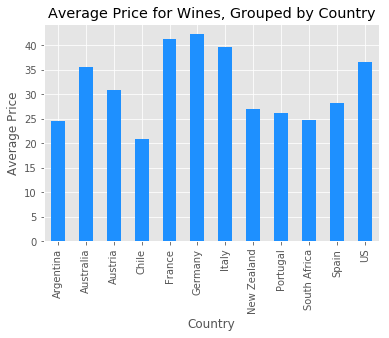

In [7]:
avg_pts_per_country = winedata.groupby('country')['price'].mean()
avg_pts_per_country.plot(kind ='bar', color = 'dodgerblue')
plt.title('Average Price for Wines, Grouped by Country')
plt.ylabel('Average Price')
plt.xlabel('Country')

For predictive models, it is necessary to convert categorical variables into integers.  This has been done for the 'country' and 'variety' features in the dataset.

In [8]:
winedata["label"] = winedata["country"].astype('category')
winedata["label"] = winedata["label"].cat.codes
winedata.label.unique()

array([ 8, 11, 10,  6,  4,  5,  0,  3,  1,  2,  9,  7])

In [9]:
winedata['variety_label'] = winedata["variety"].astype('category')
winedata["variety_label"] = winedata["variety_label"].cat.codes
winedata.variety_label.unique()

array([386, 374, 411, 378, 508, 162, 184,  66, 110, 239, 505, 276, 405,
       597, 277, 332, 122, 440, 584, 393,  98, 170, 216, 356, 295,  51,
       206, 433,  58, 106,  50,   1, 357,  91,   5, 355, 420, 604, 575,
       418, 212, 583, 573, 197, 481, 327, 460, 368,  12,  34, 407, 389,
       189, 499, 439, 537, 398, 168, 564, 166, 367,  49, 458, 296, 304,
       196, 557, 495,  44, 164,  85, 448,  75, 395, 581, 474, 313, 311,
       466, 172, 372, 503, 136, 275, 605, 331, 274, 408,  81, 567, 265,
       449, 222, 487, 143, 186, 592, 176, 377, 382, 497, 379,  18,  69,
       566, 571, 568, 468, 132,  94, 479, 157, 165, 472, 424,  28, 127,
       521, 315, 388, 291, 600, 194, 546, 138, 123, 215, 282, 409,  71,
       385, 595, 544, 502, 266, 108, 435, 394, 457, 396, 601, 153, 173,
       329, 308, 483, 324, 376,  73,  25, 511, 432, 498, 346, 322, 443,
       129, 454,  39, 540, 300, 417, 593,  32, 253, 182, 246, 293, 249,
       243, 406, 555,  15, 429, 524, 410, 545, 105, 227, 103, 22

In [10]:
print ("Number of unique countries represented in cleaned dataset: " + str(len(winedata.label.unique())))

Number of unique countries represented in cleaned dataset: 12


In [11]:
print ("Number of unique wine varieties represented in cleaned dataset: " + str(len(winedata.variety_label.unique())))

Number of unique wine varieties represented in cleaned dataset: 607


Can **points**, **price**, and **variety** be used predictively?  The following section tests the predictive power of a logistic regression model created from the dataset. 

In [12]:
feature_cols = ['points', 'price']
X = winedata[feature_cols] # Features
y = winedata.label # Target variable

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   899],
       [    0,     0,     0,     0,     3,     0,     0,     0,     0,
            0,     0,   569],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   727],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  1107],
       [    0,     0,     0,     0,     7,     0,     0,     0,     0,
            0,     0,  4417],
       [    0,     0,     0,     0,     1,     0,     0,     0,     0,
            0,     0,   536],
       [    0,     0,     0,     0,     2,     0,     0,     0,     0,
            0,     0,  4202],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   358],
       [    0,     0,     0,     0,     2,     0,     0,     0,     0,
            0,     0,  1188],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0

In [14]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.46202937700489616


This accuracy is significant, as the model, with 46% percent accuracy can determine what country a given wine is from.

However, US, French, and Italian wines are **significantly** overrepresented in the dataset. This can be rectified by undersampling.

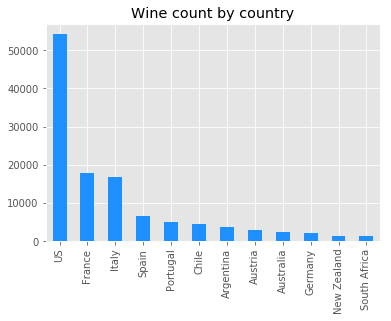

In [15]:
counts = winedata.country.value_counts()
counts.plot(kind='bar', title='Wine count by country', color = 'dodgerblue')

In [16]:
print (counts)

US              54265
France          17776
Italy           16914
Spain            6573
Portugal         4875
Chile            4416
Argentina        3756
Austria          2799
Australia        2294
Germany          2120
New Zealand      1378
South Africa     1293
Name: country, dtype: int64


54265
6573
Random under-sampling:
11    6573
10    6573
6     6573
4     6573
8     4875
3     4416
0     3756
2     2799
1     2294
5     2120
7     1378
9     1293
Name: label, dtype: int64


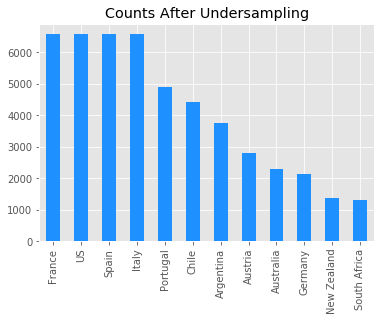

In [17]:
count_class_0 = counts['US']
count_class_1 = counts['France']
count_class_2 = counts['Italy']
count_class_3 = counts['Spain']
print (count_class_0)
print (count_class_3)

spain = winedata[winedata.country == 'Spain']
usa = winedata[winedata.country == 'US']
france = winedata[winedata.country == 'France']
italy = winedata[winedata.country == 'Italy']

other_countries = winedata[(winedata.country != 'Spain') & (winedata.country != 'US') & (winedata.country != 'France') & (winedata.country != 'Italy')]


usa_under = usa.sample(count_class_3)
france_under = france.sample(count_class_3)
italy_under = italy.sample(count_class_3)


df_test_under = pd.concat([usa_under, france_under, italy_under, spain, other_countries], axis=0)

print('Random under-sampling:')
print(df_test_under.label.value_counts())

df_test_under.country.value_counts().plot(kind='bar', title='Counts After Undersampling', color = 'dodgerblue');

Now, create another logistic regression model from the data and test it.

In [18]:
feature_cols = ['price','points']
X = df_test_under[feature_cols] # Features
y = df_test_under.label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.15293352836014953


This is now significantly less accurate, now that the data has been balanced. 

Let's do some feature engineering and include the top five countries.  Countries from other countries will be labelled as 'Other'.

In [19]:
df_test_under.country.value_counts()

France          6573
US              6573
Spain           6573
Italy           6573
Portugal        4875
Chile           4416
Argentina       3756
Austria         2799
Australia       2294
Germany         2120
New Zealand     1378
South Africa    1293
Name: country, dtype: int64

In [20]:
df_test_under.loc[(df_test_under['country'] == 'Austria') | (df_test_under['country'] == 'Australia') |(df_test_under['country'] == 'Germany')| (df_test_under['country'] == 'Chile') |(df_test_under['country'] == 'South Africa') |(df_test_under['country'] == 'New Zealand') |(df_test_under['country'] == 'Argentina'), 'country'] = 'Other'

In [21]:
newcounts = df_test_under.country.value_counts()
print (newcounts)

Other       18056
France       6573
US           6573
Spain        6573
Italy        6573
Portugal     4875
Name: country, dtype: int64


In [22]:
df_test_under.country.value_counts()

Other       18056
France       6573
US           6573
Spain        6573
Italy        6573
Portugal     4875
Name: country, dtype: int64

Now, let's do some undersampling for the 'Other' category.

In [23]:
count_class_0 = newcounts['Other']
count_class_1 = newcounts['US']

usa = df_test_under[df_test_under.country == 'US']
other = df_test_under[df_test_under.country == 'Other']

other_under = other.sample(count_class_1)

non_other = df_test_under[(df_test_under.country != 'Other')]

df_test_under = pd.concat([other_under, non_other], axis=0)

In [24]:
df_test_under.country.value_counts()

France      6573
Other       6573
US          6573
Spain       6573
Italy       6573
Portugal    4875
Name: country, dtype: int64

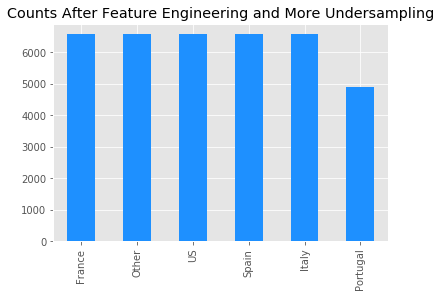

In [25]:
df_test_under.country.value_counts().plot(kind='bar', title='Counts After Feature Engineering and More Undersampling', color = 'dodgerblue');

Now let's test the accuracy of logistic regression.

In [26]:
feature_cols = ['price','points']
X = df_test_under[feature_cols] # Features
y = df_test_under.label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.21049284578696342


Perhaps including 'variety' as a feature will enhance accuracy:

In [27]:
feature_cols = ['price','points', 'variety_label']
X = df_test_under[feature_cols] # Features
y = df_test_under.label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.2678325384207737


Adding 'variety' as a feature does enhance accuracy.  However, the 'variety' feature may be unbalanced as well.

In [28]:
variety_counts = winedata.variety.value_counts()
print (variety_counts)

Pinot Noir                  12699
Chardonnay                  10922
Cabernet Sauvignon           9208
Red Blend                    8165
Bordeaux-style Red Blend     5264
Riesling                     4899
Sauvignon Blanc              4688
Syrah                        4028
Rosé                         3204
Merlot                       2966
Zinfandel                    2708
Malbec                       2587
Sangiovese                   2376
Nebbiolo                     2325
Portuguese Red               2196
White Blend                  1992
Sparkling Blend              1959
Tempranillo                  1784
Rhône-style Red Blend        1400
Pinot Gris                   1374
Cabernet Franc               1265
Champagne Blend              1205
Grüner Veltliner             1144
Portuguese White              986
Pinot Grigio                  983
Viognier                      970
Gewürztraminer                939
Gamay                         836
Shiraz                        790
Petite Sirah  

In [29]:
print (len(variety_counts))

606


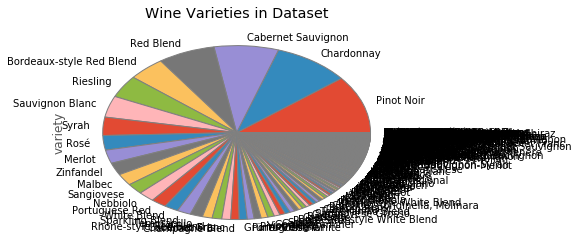

In [30]:
variety_counts.plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})
plt.title('Wine Varieties in Dataset')

The 'variety' feature is unbalanced. 'Pinot Noir', 'Chardonnay', and 'Cabernet Sauvignon' are highly overrepresented, as these three wines account for over one fourth of 606 wine varieties in the data.

Let's do some feature engineering, then balance 'variety', and then try to use it as a predictive feature.

In [31]:
newwinedf = df_test_under

In [32]:
df_test_under.variety.value_counts()

Red Blend                     2919
Chardonnay                    2349
Portuguese Red                2196
Pinot Noir                    2174
Cabernet Sauvignon            1655
Bordeaux-style Red Blend      1562
Tempranillo                   1457
Riesling                      1410
Sauvignon Blanc               1196
Rosé                          1184
Portuguese White               986
Nebbiolo                       883
Sparkling Blend                881
Malbec                         814
Sangiovese                     814
White Blend                    796
Syrah                          734
Tempranillo Blend              577
Merlot                         532
Port                           448
Champagne Blend                419
Grüner Veltliner               388
Albariño                       357
Rhône-style Red Blend          344
Garnacha                       312
Gamay                          305
Zinfandel                      301
Verdejo                        288
Pinot Gris          

In [33]:
newwinedf.loc[(newwinedf['variety'] != 'Pinot Noir') & (newwinedf['variety'] != 'Chardonnay') &(newwinedf['variety'] != 'Cabernet Sauvignon')& (newwinedf['variety'] != 'Red Blend') &(newwinedf['variety'] != 'Bordeaux-style Red Blend') &(newwinedf['variety'] != 'Riesling Sauvignon') &(newwinedf['variety'] != 'Blanc') & (newwinedf['variety'] != 'Syrah'), 'variety'] = 'Other'

In [34]:
varietycounts = newwinedf.variety.value_counts()

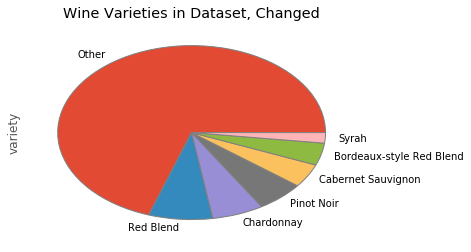

In [35]:
newwinedf.variety.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})
plt.title('Wine Varieties in Dataset, Changed')

Now, let's do undersampling for the 'Other' category.

In [36]:
count_class_0 = varietycounts['Other']
count_class_1 = varietycounts['Pinot Noir']
print (count_class_0)
print (count_class_1)

other = newwinedf[newwinedf.variety == 'Other']
pinot = newwinedf[newwinedf.variety == 'Pinot Noir']
notpinotorother = newwinedf[(newwinedf.variety != 'Other') & (newwinedf.variety != 'Pinot Noir')]


other_under = other.sample(count_class_1)
df_test_under = pd.concat([other_under, pinot, notpinotorother], axis=0)

26347
2174


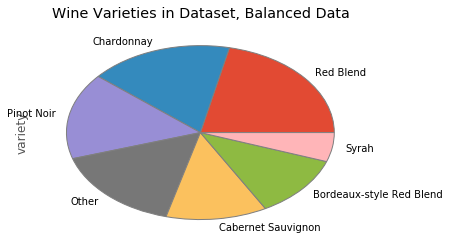

In [37]:
df_test_under.variety.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})
plt.title('Wine Varieties in Dataset, Balanced Data')

In [38]:
df_test_under.head()

,country,description,designation,points,price,region,sub_region,taster_name,taster_twitter_handle,title,variety,winery,label,variety_label
68081,Other,Not as dark and sticky as many wines of this v...,Gran Reserva de los Andes,85,12.0,Maipo Valley,NaN,Michael Schachner,@wineschach,Santa Alicia 2007 Gran Reserva de los Andes Ca...,Other,Santa Alicia,3,91
37715,Portugal,"Lightly prickly on the tongue, this is a refre...",Aveleda,86,9.0,Vinho Verde,NaN,Roger Voss,@vossroger,Aveleda 2015 Aveleda White (Vinho Verde),Other,Aveleda,8,389
15231,Portugal,"This blend of local Douro white grapes with, u...",Reserva Branco,90,29.0,Douro,NaN,Roger Voss,@vossroger,Colinas do Douro 2015 Reserva Branco White (Do...,Other,Colinas do Douro,8,389
97568,US,"A very nice Sauvignon Blanc, and a good follow...",NaN,89,18.0,California,Napa Valley,NaN,NaN,Trailhead 2010 Sauvignon Blanc (Napa Valley),Other,Trailhead,11,440
76589,France,"A dusty-textured wine, its fruit like grains s...",Clos Mireille,90,37.0,Provence,Côtes de Provence,Roger Voss,@vossroger,Domaines Ott 2009 Clos Mireille Rosé (Côtes de...,Other,Domaines Ott,4,420


In [39]:
df_test_under['variety_label'] = df_test_under["variety"].astype('category')
df_test_under['variety_label'] = df_test_under['variety_label'].cat.codes
df_test_under.label.unique()

array([ 3,  8, 11,  4, 10,  5,  6,  0,  1,  9,  2,  7])

In [40]:
feature_cols = ['price','points', 'variety_label']
X = df_test_under[feature_cols] # Features
y = df_test_under.label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3089622641509434


Doing some featuring engineering and balancing on the 'variety' feature provides greater predictive accuracy.  This model, is, with almost 30% accuracy predicting whether a given wine comes from the US, France, Italy, Spain, Portugal, or 'Other'.

However, 'variety' can often be region-specific, and this don't necessarily provide us with many meaningful conclusions about the data.

To enhance predictive accuracy and obtain meaningful conclusions about the data, it was decided to separate the wine reviews data into three categories: French wines, Italian wines, and California wines (which account for the majority of US wines in the data):

In [73]:
frenchwines = winedata[winedata['country'] == 'France'].reset_index()
italianwines = winedata[winedata['country'] == 'Italy'].reset_index()
uswines = winedata[winedata['country'] == 'US'].reset_index()
caliwines = uswines[uswines['region'] == 'California']

# French Wines

In [44]:
frenchwines.head()

,index,country,description,designation,points,price,region,sub_region,taster_name,taster_twitter_handle,title,variety,winery,label,variety_label
0,6,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,4,184
1,8,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,4,374
2,10,France,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,Roger Voss,@vossroger,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer,4,184
3,37,France,"This is a festive wine, with soft, ripe fruit ...",Nouveau,86,9.0,Beaujolais,Beaujolais,Roger Voss,@vossroger,Henry Fessy 2012 Nouveau (Beaujolais),Gamay,Henry Fessy,4,170
4,44,France,"Soft and fruity, this is a generous, ripe wine...",Eté Indien,86,14.0,Beaujolais,Brouilly,Roger Voss,@vossroger,Vignerons de Bel Air 2011 Eté Indien (Brouilly),Gamay,Vignerons de Bel Air,4,170


The French wines all have a region category.  Does 'region' have any impact on price or rating?  Let's look closer at this 'region' feature.

In [78]:
frenchwines['region'].value_counts()

Bordeaux                4002
Burgundy                3106
Alsace                  2147
Loire Valley            1598
Champagne               1383
Southwest France        1335
Provence                1139
Rhône Valley            1042
Beaujolais               846
France Other             589
Languedoc-Roussillon     589
Name: region, dtype: int64

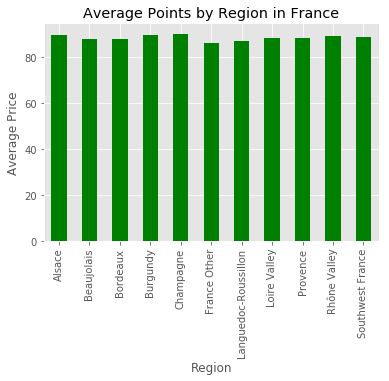

In [79]:
avg_points_per_region = frenchwines.groupby('region')['points'].mean()
avg_points_per_region.plot(kind ='bar', color = 'green')
plt.title('Average Points by Region in France')
plt.ylabel('Average Price')
plt.xlabel('Region')

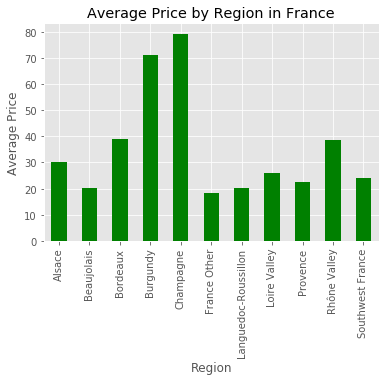

In [80]:
avg_price_per_region = frenchwines.groupby('region')['price'].mean()
avg_price_per_region.plot(kind ='bar', color = 'green')
plt.title('Average Price by Region in France')
plt.ylabel('Average Price')
plt.xlabel('Region')

Interestingly, the average number of points reviewers gave to wines were similar for all regions in France; however, on average, wines from the **Burgundy** and **Champagne** regions were much more expensive than wines from other regions. 

However, is this phenomenon due to outliers? Outliers are typically understood as data points that have a z-score greater than 3.  The next step is to remove the outliers. 

In [81]:
standardized = frenchwines.groupby('points').transform(zscore)
outliers = (standardized['price'] > 3) | (standardized['price'] < -3)
frwines_outliers = frenchwines.loc[outliers]

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:2248: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


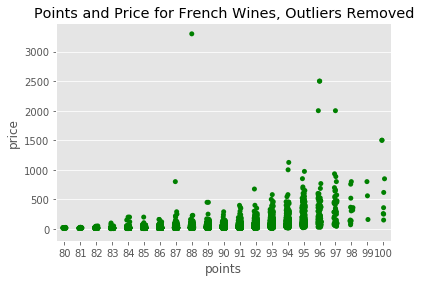

In [82]:
common = frenchwines.merge(frwines_outliers,on=['index'])
newfrenchwines = frenchwines[(~frenchwines.index.isin(common.index))]
sns.stripplot(data=newfrenchwines, x='points', y='price', jitter = True, color = "green")
plt.title('Points and Price for French Wines, Outliers Removed')

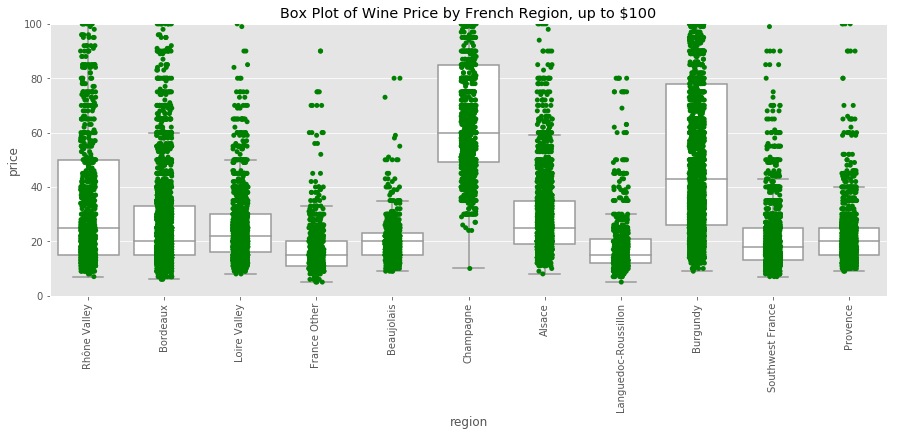

In [83]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='region', y='price', data=newfrenchwines, showfliers=False, color='white')
sns.stripplot(x='region', y='price', data=newfrenchwines, color="green", jitter = True)
plt.ylim(0, 100)
plt.xticks(rotation=90)
plt.title("Box Plot of Wine Price by French Region, up to $100")

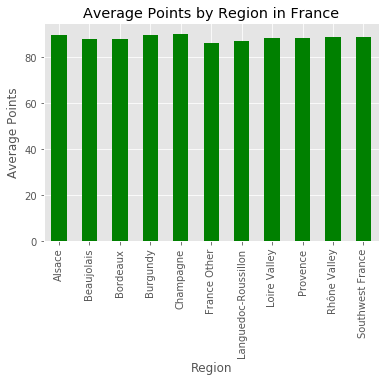

In [84]:
avg_points_per_region_new = newfrenchwines.groupby('region')['points'].mean()
avg_points_per_region_new.plot(kind ='bar', color = 'green')
plt.title('Average Points by Region in France')
plt.ylabel('Average Points')
plt.xlabel('Region')

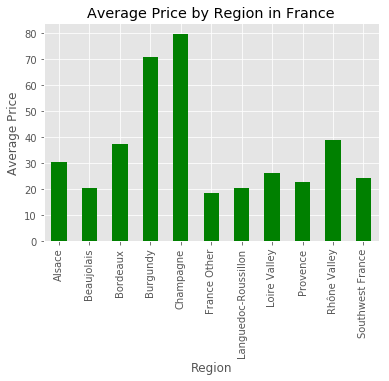

In [85]:
avg_price_per_region_new = newfrenchwines.groupby('region')['price'].mean()
avg_price_per_region_new.plot(kind ='bar', color = 'green')
plt.title('Average Price by Region in France')
plt.ylabel('Average Price')
plt.xlabel('Region')

The two bar charts above show that 'points' are not significantly impacted by region of origin, but price definitely is.

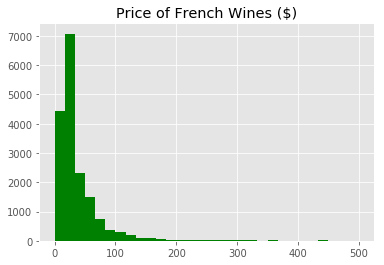

In [86]:
plt.hist(newfrenchwines['price'],range=(0,500), bins= 30 , color = 'green')
plt.title('Price of French Wines ($)')

This data is skewed to the right.  Nonetheless, it may be possible to use the t-test for non-normal data with a large enough sample size.  The t-test is calculated below.

In [87]:
champagneandburgundy = frenchwines[(frenchwines['region']=='Burgundy') | (frenchwines['region']=='Champagne')]
otherfrenchregions = frenchwines[(frenchwines['region']!='Burgundy') & (frenchwines['region']!='Champagne')]
ttest_ind(champagneandburgundy['price'], otherfrenchregions['price'])

Ttest_indResult(statistic=35.32778806213724, pvalue=2.81022777051498e-264)

The low p-value indicates that the discrepancy between average price of wines from the Champagne and Burgundy regions as opposed to other regions in France is not coincidental. Because the t-test assumes normality (which is not represented in the price data), it is good to also perform a non-parametric test. The Wilcoxon Sign-Ranked Test and the Mann-Whitney U Test are often used as an alternative to Student's T-test for non-normal data.

In [88]:
stats.mannwhitneyu(champagneandburgundy['price'], otherfrenchregions['price'])

MannwhitneyuResult(statistic=10115279.0, pvalue=0.0)

The p-value for the Mann-Whitney U Test also indicates that the differences between the two groups is statistically significant.

We can also use log-normalization to make this data more normal.

In [89]:
newfrenchwines['log_price'] = np.log(newfrenchwines['price'])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.500e+01, 8.310e+02,
        3.566e+03, 4.248e+03, 3.530e+03, 2.143e+03, 1.708e+03, 7.580e+02,
        3.630e+02, 1.440e+02, 1.190e+02, 5.700e+01, 2.000e+01, 4.000e+00,
        2.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. ]),
 <a list of 25 Patch objects>)

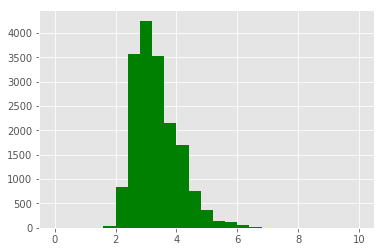

In [90]:
plt.hist(newfrenchwines['log_price'],range=(0,10), bins= 25 , color = 'green')


After applying log-normalization, the data is much less skewed. 

In [91]:
newfrenchwines.head()

,index,country,description,designation,points,price,region,sub_region,taster_name,taster_twitter_handle,title,variety,winery,label,variety_label,log_price
243,1562,France,"Not a big, overwhelming blockbuster, this harm...",NaN,90,40.0,Rhône Valley,Châteauneuf-du-Pape,Joe Czerwinski,@JoeCz,Réserve des Oliviers 2009 White (Châteauneuf-d...,Rhône-style White Blend,Réserve des Oliviers,4,408,3.688879
244,1563,France,"Like many of the '07 Hermitages, this isn't a ...",NaN,90,126.0,Rhône Valley,Hermitage,Joe Czerwinski,@JoeCz,Tardieu-Laurent 2007 Hermitage,Syrah,Tardieu-Laurent,4,481,4.836282
245,1575,France,"Rich and broad in the mouth, with notes of hon...",Vieilles Vignes,90,63.0,Rhône Valley,Châteauneuf-du-Pape,Joe Czerwinski,@JoeCz,Tardieu-Laurent 2009 Vieilles Vignes White (Ch...,Rhône-style White Blend,Tardieu-Laurent,4,408,4.143135
246,1613,France,"Rounded and rich, this generous, full-bodied w...",NaN,92,135.0,Bordeaux,Saint-Émilion,Roger Voss,@vossroger,Le Carré 2012 Saint-Émilion,Bordeaux-style Red Blend,Le Carré,4,50,4.905275
247,1624,France,"One of the few great values from Pauillac, thi...",NaN,92,49.0,Bordeaux,Pauillac,Roger Voss,@vossroger,Château Gaudin 2011 Pauillac,Bordeaux-style Red Blend,Château Gaudin,4,50,3.891820


In [92]:
newfrenchwines["region_label"] = newfrenchwines["region"].astype('category')
newfrenchwines["region_label"] = newfrenchwines["region_label"].cat.codes
newfrenchwines.region_label.unique()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([ 9,  2,  7,  5,  1,  4,  0,  6,  3, 10,  8])

In [93]:
feature_cols = ['points', 'log_price']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.region_label # Target variable

In [94]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 27,   0, 424, 103,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0, 192,   5,   0,   0,   0,   0,   0,   0,   0],
       [  3,   0, 829, 189,   1,   0,   0,   0,   0,   0,   0],
       [  2,   0, 325, 407,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,  20, 310,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 122,   6,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 120,  12,   0,   0,   0,   0,   0,   0,   0],
       [  6,   0, 354,  53,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0, 239,  23,   0,   0,   0,   0,   0,   0,   0],
       [  4,   0, 173,  86,   0,   0,   0,   0,   0,   0,   0],
       [ 11,   0, 290,  45,   0,   0,   0,   0,   0,   0,   0]])

In [95]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.2880930656934307


Does adding 'variety' as a feature improve accuracy?

Complete the feature engineering and undersampling steps for the 'variety_label" feature as in previous section:

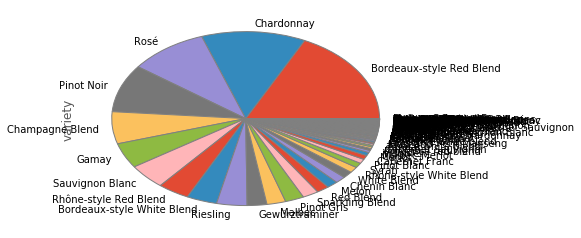

In [96]:
newfrenchwines.variety.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

In [97]:
newfrenchwines.loc[(newfrenchwines['variety'] != 'Chardonnay') & (newfrenchwines['variety'] != 'Rosé') &(newfrenchwines['variety'] != 'Pinot Noir') &(newfrenchwines['variety'] != 'Bordeaux-style Red Blend') &(newfrenchwines['variety'] != 'Champagne Blend'), 'variety'] = 'Other'

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


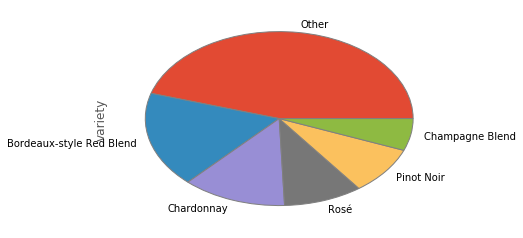

In [98]:
newfrenchwines.variety.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

In [ ]:
varietycounts = newfrenchwines.variety.value_counts()

In [99]:
count_class_0 = varietycounts['Other']
count_class_1 = varietycounts['Chardonnay']
print (count_class_0)
print (count_class_1)

other = newfrenchwines[newfrenchwines.variety == 'Other']
chardonnay = newfrenchwines[newfrenchwines.variety == 'Chardonnay']
notchardonnayorother = newfrenchwines[(newfrenchwines.variety != 'Other') & (newfrenchwines.variety != 'Chardonnay')]


other_under = other.sample(count_class_1)
newfrenchwines = pd.concat([other_under, notchardonnayorother, chardonnay], axis=0)

26449
2351


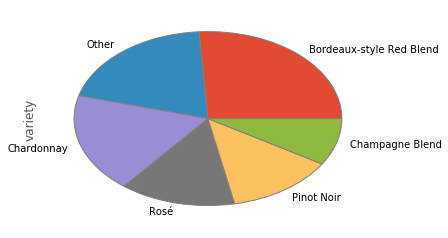

In [100]:
newfrenchwines.variety.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

In [101]:
newfrenchwines.variety.value_counts()

Bordeaux-style Red Blend    3112
Other                       2351
Chardonnay                  2206
Rosé                        1668
Pinot Noir                  1559
Champagne Blend             1044
Name: variety, dtype: int64

In [102]:
newfrenchwines['variety_label'] = newfrenchwines["variety"].astype('category')
newfrenchwines["variety_label"] = newfrenchwines["variety_label"].cat.codes
newfrenchwines.variety_label.unique()

array([3, 0, 4, 5, 1, 2])

In [103]:
feature_cols = ['points', 'log_price', 'variety_label']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[  0,   0,   8, 162,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  19,  51,   0,   0,   0,   0,   2,   0,   0],
       [  0,   0, 749,  42,  29,   0,   0,   0,  46,   0,   0],
       [  0,   0, 142, 594,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0, 132, 193,  22,   0,   0,   0,   0,   0,   0],
       [  0,   0,  17,  23,   0,   5,   0,   0,  23,   0,   0],
       [  0,   0,  18,  31,   0,   4,   0,   0,  39,   0,   0],
       [  0,   0,  13, 102,   0,   0,   0,   0,  29,   0,   0],
       [  0,   0,   0,  26,   0,   0,   0,   0, 224,   0,   0],
       [  0,   0,   8,  49,   0,   1,   0,   0,  45,   0,   0],
       [  0,   0,  45,  71,   0,   0,   0,   0,  20,   0,   0]])

In [104]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5340033500837521


Including variety creates higher accuracy. Perhaps accuracy can be even further improved -- perhaps there are too many labels, and it would make more sense to subdivide the French wines into two categories: Champagne/Burgundy or Other region, based on prior analysis.  This approach makes sense, given the fact that linear regression is mainly used in cases when the output is boolean (https://medium.com/@sangha_deb/naive-bayes-vs-logistic-regression-a319b07a5d4c).

In [105]:
def label_fr_region (row):
    if row['region'] == 'Burgundy' or row['region'] == 'Champagne':
        return 0
    else:
        return 1
#frenchwines.apply (lambda row: label_fr_region(row), axis=1)
newfrenchwines['new_region_label'] = newfrenchwines.apply (lambda row: label_fr_region(row), axis=1)
newfrenchwines.head(50)

,index,country,description,designation,points,price,region,sub_region,taster_name,taster_twitter_handle,title,variety,winery,label,variety_label,log_price,region_label,new_region_label
11038,72709,France,"From the ripe 2015 vintage, this is a smooth o...",Les Belles Côtes,89,46.0,Loire Valley,Sancerre,Roger Voss,@vossroger,Roger et Didier Raimbault 2015 Les Belles Côte...,Other,Roger et Didier Raimbault,4,3,3.828641,7,1
5779,38782,France,Sweet red peach flavors combine with honey in ...,NaN,87,31.0,Bordeaux,Cadillac,Roger Voss,@vossroger,Château Suau 2005 Cadillac,Other,Château Suau,4,3,3.433987,2,1
1736,12007,France,Modest apple and citrus aromas are clean and p...,Héritages,87,16.0,Rhône Valley,Côtes du Rhône,Joe Czerwinski,@JoeCz,Ogier 2013 Héritages White (Côtes du Rhône),Other,Ogier,4,3,2.772589,9,1
8547,56523,France,A distinctly aromatic nose tells of honeysuckl...,Grains de Génie,86,14.0,Alsace,Alsace,Anne Krebiehl MW,@AnneInVino,Domaine Michel Fonne 2014 Grains de Génie Whit...,Other,Domaine Michel Fonne,4,3,2.639057,0,1
4623,31128,France,"Structured, smoky and full of black cherry fru...",Nouveau,86,13.0,Beaujolais,Beaujolais-Villages,Roger Voss,@vossroger,Henry Fessy 2014 Nouveau (Beaujolais-Villages),Other,Henry Fessy,4,3,2.564949,1,1
4191,28146,France,"There's a wild, natural streak to this wine of...",NaN,87,15.0,Languedoc-Roussillon,Fitou,Lauren Buzzeo,@laurbuzz,Mourrel Azurat 2009 Red (Fitou),Other,Mourrel Azurat,4,3,2.708050,6,1
7406,49072,France,"Round and pillowy in feel, this is a simple wi...",Nobles Rives,85,13.0,Rhône Valley,Collines Rhôdaniennes,Joe Czerwinski,@JoeCz,Cave de Tain 2015 Nobles Rives Marsanne (Colli...,Other,Cave de Tain,4,3,2.564949,9,1
17460,116626,France,"Crisp grapefruit and citrus character, with ti...",Cuvée Prestige Sur Lie,86,12.0,Loire Valley,Muscadet Coteaux de la Loire,Roger Voss,@vossroger,Domaine Guindon 2008 Cuvée Prestige Sur Lie (...,Other,Domaine Guindon,4,3,2.484907,7,1
9269,61325,France,Blueberries and blackberries are the dominant ...,NaN,88,13.0,Rhône Valley,Crozes-Hermitage,Joe Czerwinski,@JoeCz,Domaine des Entrefaux 1999 Crozes-Hermitage,Other,Domaine des Entrefaux,4,3,2.564949,9,1
1975,13713,France,With some firm tannins and considerable red fr...,NaN,89,21.0,Beaujolais,Saint-Amour,Roger Voss,@vossroger,Domaine de Billards 2009 Saint-Amour,Other,Domaine de Billards,4,3,3.044522,1,1


In [106]:
feature_cols = ['points', 'log_price']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7993299832495813


Does including variety label enhance accuracy?

In [107]:
feature_cols = ['points', 'log_price', 'variety_label']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.802680067001675


Is knn more accurate than logistic regression?

In [108]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.969179229480737


Knn is extremely accurate for determining whether a given wine is from Burgundy/Champagne or another region is France, based on the 'points', 'log_price', and 'variety_label' features.

How is this accurate changed if we omit some of the features?

In [109]:
feature_cols = ['points', 'log_price']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.787604690117253


In [110]:
feature_cols = ['points', 'variety_label']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.9510887772194305


In [111]:
feature_cols = ['log_price', 'variety_label']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.9644891122278056


In [112]:
feature_cols = ['variety_label']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.9597989949748744


In [113]:
feature_cols = ['points']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.6847571189279732


In [114]:
feature_cols = ['log_price']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.7685092127303182


'Variety' and 'price' are the most useful features for predicting region of origin for French wines.

One of the reasons that this accuracy may be so high is that the "Burgundy/Champagne" and "Other Regions" categories are unbalanced.  Let's balance these categories and then redo the predictions.  

In [115]:
counts = newfrenchwines.new_region_label.value_counts()
print('Burgundy or Champagne Wines:', counts[0])
print('Other French Wines:', counts[1])
print('Proportion:', round(counts[0] / counts[1], 2), ': 1')

Burgundy or Champagne Wines: 4366
Other French Wines: 7574
Proportion: 0.58 : 1


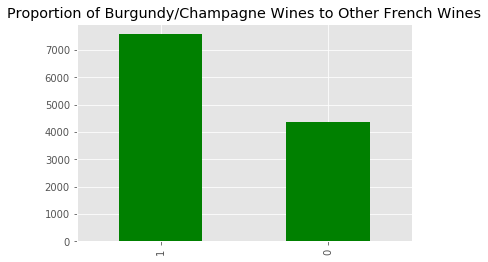

In [116]:
counts.plot(kind='bar', title='Proportion of Burgundy/Champagne Wines to Other French Wines', color='green')

In [117]:
count_class_0, count_class_1 = newfrenchwines.new_region_label.value_counts()

Random under-sampling:
1    4366
0    4366
Name: new_region_label, dtype: int64


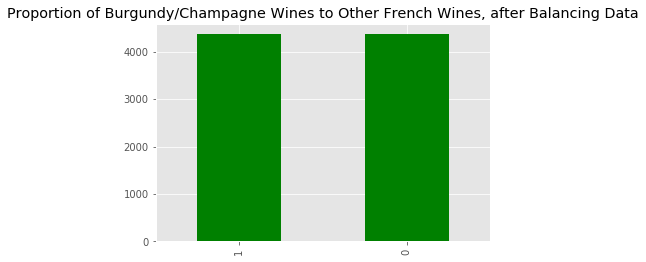

In [118]:
df_class_burg_or_champ = newfrenchwines[newfrenchwines.new_region_label == 0]
df_class_other_fren_wines = newfrenchwines[newfrenchwines.new_region_label == 1]
df_class_other_fren_wines_under = df_class_other_fren_wines.sample(count_class_1)
df_test_under = pd.concat([df_class_other_fren_wines_under, df_class_burg_or_champ], axis=0)
print('Random under-sampling:')
print(df_test_under.new_region_label.value_counts())

df_test_under.new_region_label.value_counts().plot(kind='bar', title='Proportion of Burgundy/Champagne Wines to Other French Wines, after Balancing Data', color=
                                                  'green');

In [119]:
feature_cols = ['points', 'log_price', 'variety_label']
X = df_test_under[feature_cols] # Features
y = df_test_under.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7814933577645442


In [120]:
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.9638112688960147


In [121]:
feature_cols = ['points', 'log_price']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.787604690117253


In [122]:
feature_cols = ['points', 'variety_label']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.9510887772194305


In [123]:
feature_cols = ['log_price', 'variety_label']
X = newfrenchwines[feature_cols] # Features
y = newfrenchwines.new_region_label # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.9644891122278056


The accuracy is still quite strong after balancing the region labels.  The price and variety are the most important predictive features.

# Italian Wines

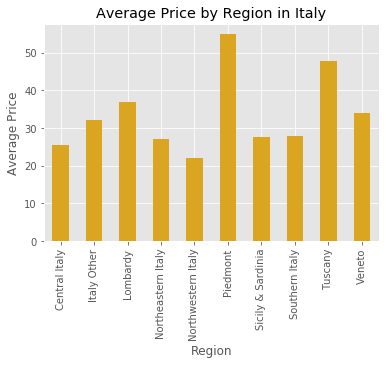

In [124]:
avg_price_per_region = italianwines.groupby('region')['price'].mean()
avg_price_per_region.plot(kind ='bar', color = 'goldenrod')
plt.title('Average Price by Region in Italy')
plt.ylabel('Average Price')
plt.xlabel('Region')

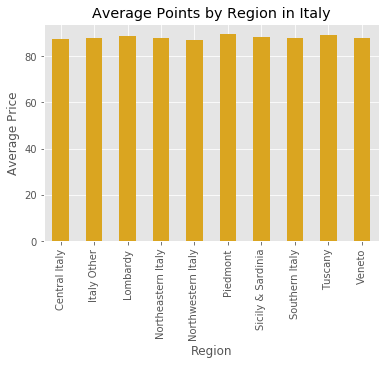

In [125]:
avg_points_per_region = italianwines.groupby('region')['points'].mean()
avg_points_per_region.plot(kind ='bar', color = 'goldenrod')
plt.title('Average Points by Region in Italy')
plt.ylabel('Average Price')
plt.xlabel('Region')

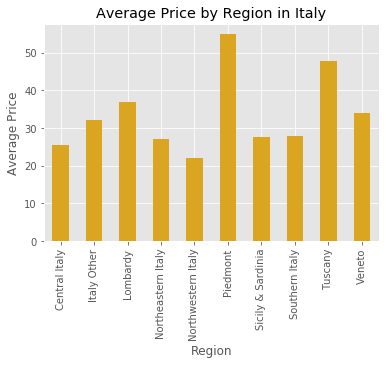

In [126]:
avg_price_per_region = italianwines.groupby('region')['price'].mean()
avg_price_per_region.plot(kind ='bar', color = 'goldenrod')
plt.title('Average Price by Region in Italy')
plt.ylabel('Average Price')
plt.xlabel('Region')

Similar to what was observed with the French wines, Italian wines received similar ratings, but wines from the **Piedmont** and **Tuscany** regions tended to be significantly more expensive than wines from other regions. 

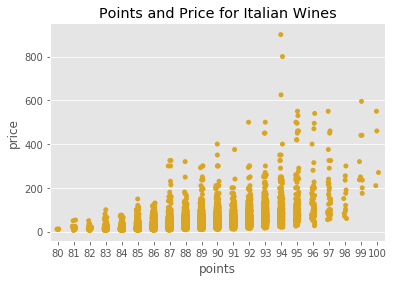

In [127]:
sns.stripplot(data=italianwines, x='points', y='price', jitter = True, color = "goldenrod")
plt.title('Points and Price for Italian Wines')

Next, remove outliers, defined as data points with z-scores greater than 3.

In [128]:
standardized = italianwines.groupby('points').transform(zscore)
outliers = (standardized['price'] > 3) | (standardized['price'] < -3)
itwines_outliers = italianwines.loc[outliers]
common = italianwines.merge(itwines_outliers,on=['index'])
newitalianwines = italianwines[(~italianwines.index.isin(common.index))]

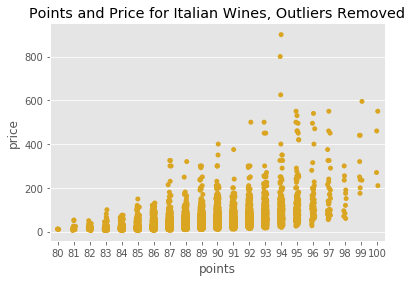

In [129]:
sns.stripplot(data=newitalianwines, x='points', y='price', jitter = True, color = "goldenrod")
plt.title('Points and Price for Italian Wines, Outliers Removed')

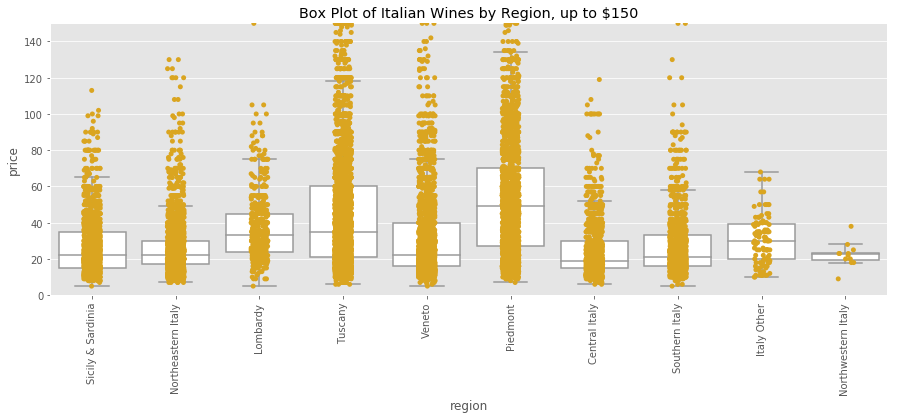

In [130]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='region', y='price', data=newitalianwines, showfliers=False, color='white')
sns.stripplot(x='region', y='price', data=newitalianwines, color="goldenrod", jitter = True)
plt.ylim(0, 150)
plt.xticks(rotation=90)
plt.title('Box Plot of Italian Wines by Region, up to $150')

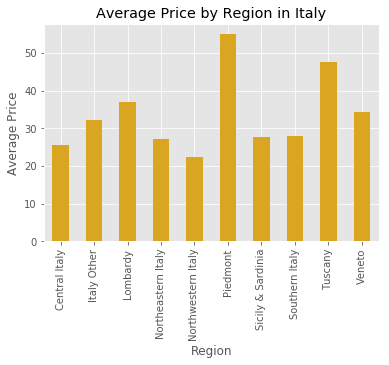

In [131]:
avg_price_per_region = newitalianwines.groupby('region')['price'].mean()
avg_price_per_region.plot(kind ='bar', color = 'goldenrod')
plt.title('Average Price by Region in Italy')
plt.ylabel('Average Price')
plt.xlabel('Region')

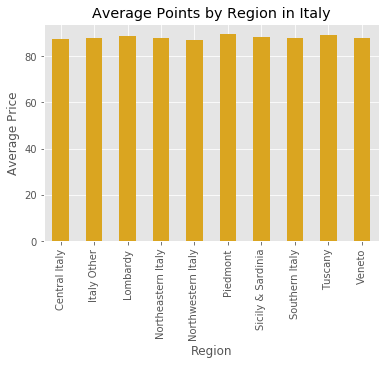

In [132]:
avg_points_per_region = newitalianwines.groupby('region')['points'].mean()
avg_points_per_region.plot(kind ='bar', color = 'goldenrod')
plt.title('Average Points by Region in Italy')
plt.ylabel('Average Price')
plt.xlabel('Region')

Even after removing many outliers, wines from Piedmont and Tuscany are significantly more expensive than wines from other regions.  This discrepancy is not reflected in the ratings. 

(array([1.368e+03, 6.561e+03, 2.668e+03, 2.325e+03, 1.419e+03, 7.740e+02,
        6.030e+02, 3.000e+02, 1.100e+02, 1.710e+02, 4.900e+01, 5.700e+01,
        3.900e+01, 2.600e+01, 1.500e+01, 2.600e+01, 9.000e+00, 1.200e+01,
        1.800e+01, 5.000e+00, 3.000e+00, 6.000e+00, 1.100e+01, 1.000e+00,
        8.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 3.000e+00]),
 array([  0.        ,  13.33333333,  26.66666667,  40.        ,
         53.33333333,  66.66666667,  80.        ,  93.33333333,
        106.66666667, 120.        , 133.33333333, 146.66666667,
        160.        , 173.33333333, 186.66666667, 200.        ,
        213.33333333, 226.66666667, 240.        , 253.33333333,
        266.66666667, 280.        , 293.33333333, 306.66666667,
        320.        , 333.33333333, 346.66666667, 360.        ,
        373.33333333, 386.66666667, 400.        ]),
 <a list of 30 Patch objects>)

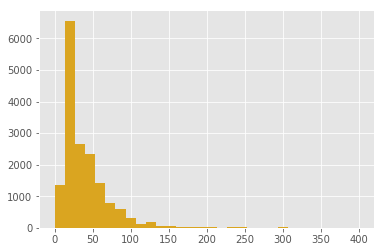

In [133]:
itprice = newitalianwines['price']
plt.hist(itprice, range=(0,400), bins= 30, color = 'goldenrod')

As with the French wines, the data is highly skewed to the right.  The t-test and the Mann-Whitney U-test are calculated for the difference between Piedmont/Tuscany wines and other Italian wines below.

In [134]:
piedmontandtuscany = newitalianwines[(newitalianwines['region']=='Piedmont') | (newitalianwines['region']=='Tuscany')]
otheritalianregions = newitalianwines[(newitalianwines['region']!='Piedmont') & (newitalianwines['region']!='Tuscany')]
ttest_ind(piedmontandtuscany['price'], otheritalianregions['price'])

Ttest_indResult(statistic=36.401715962703506, pvalue=3.27741087093885e-279)

In [135]:
stats.mannwhitneyu(piedmontandtuscany['price'], otheritalianregions['price'])

MannwhitneyuResult(statistic=20455642.5, pvalue=0.0)

The low p-values indicates that the difference in averages is not coincidental. 

Log-normalization can also be conducted to make the data more normal. 

In [136]:
newitalianwines['log_price'] = np.log(newitalianwines['price'])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.200e+01, 6.170e+02,
        2.492e+03, 3.861e+03, 3.243e+03, 2.736e+03, 2.356e+03, 8.670e+02,
        2.660e+02, 8.700e+01, 3.500e+01, 2.400e+01, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. ]),
 <a list of 25 Patch objects>)

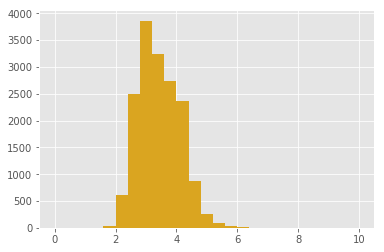

In [137]:
plt.hist(newitalianwines['log_price'],range=(0,10), bins= 25 , color = 'goldenrod')


In [138]:
newitalianwines["variety_label"] = newitalianwines["variety"].astype('category')
newitalianwines["variety_label"] = newitalianwines["variety_label"].cat.codes
newitalianwines.variety_label.unique()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([ 71, 137, 126, 170, 136, 185, 125, 104, 107,  36,   9,  94,  56,
       146, 143, 127, 132, 145, 108,  66,  93, 140,  77, 144,  33,  73,
         0,  89, 133, 163, 147,  49,  62, 152,  43,  58,  57, 116,  70,
        47, 131, 180,   2, 167,  54, 138,  41,  44,   7,  96,  20, 110,
       117,   1, 148,  74, 178,  61, 101,  52,  26, 165, 155, 112,  31,
       175, 183,   4,  78, 102,  24,  75, 149,  95,  72,  45,  81, 115,
       186,  82, 171, 129,  19, 134, 105,  88, 141,  35, 168, 139,  53,
       109, 118,  16, 113, 154,  28, 173, 159, 130,  55, 121, 156, 153,
       184, 120, 106, 176,  42,  34,  97,  68,  17, 177,  39, 128,  87,
       161, 122,  65, 119,  67, 123,  37,  86, 164,   5,  60, 100,  29,
       111,  18,  69,  76,  38,  12, 114, 182, 135, 166,  85,  91,  83,
        46, 181,  11,  63,  27,  84,  23,  13, 150,  15,  92,  59,  21,
       157, 160, 169,   3,  80, 174,  14, 172, 158,  64, 179,  98,  10,
         6,  79,  90, 142,  51, 103, 151,  40,  32,  30,  48, 16

In [143]:
newitalianwines["region_label"] = newitalianwines["region"].astype('category')
newitalianwines["region_label"] = newitalianwines["region_label"].cat.codes
newitalianwines.region.value_counts()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Tuscany               5066
Piedmont              3037
Veneto                2274
Northeastern Italy    1940
Sicily & Sardinia     1505
Southern Italy        1107
Central Italy         1089
Lombardy               478
Italy Other            111
Northwestern Italy      12
Name: region, dtype: int64

In [139]:
newitalianwines.variety.value_counts()

Red Blend                        3229
Nebbiolo                         2225
Sangiovese                       1915
White Blend                       640
Glera                             602
Sangiovese Grosso                 586
Pinot Grigio                      550
Corvina, Rondinella, Molinara     495
Barbera                           371
Nero d'Avola                      308
Chardonnay                        305
Sparkling Blend                   278
Aglianico                         277
Sauvignon                         276
Garganega                         214
Montepulciano                     175
Prosecco                          174
Moscato                           161
Verdicchio                        159
Pinot Nero                        151
Turbiana                          146
Pinot Bianco                      140
Vermentino                        139
Merlot                            136
Vernaccia                         124
Syrah                             123
Fiano       

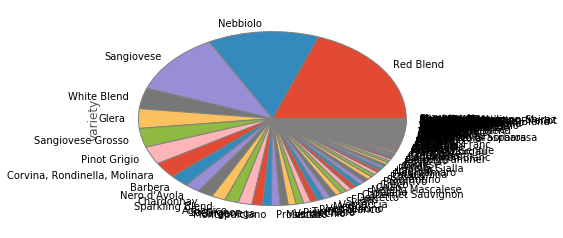

In [140]:
newitalianwines.variety.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

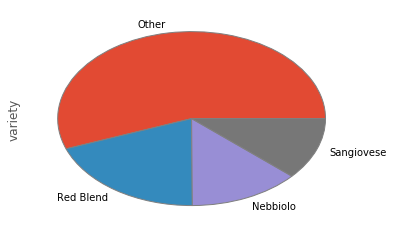

In [144]:
newitalianwines.loc[(newitalianwines['variety'] != 'Red Blend') & (newitalianwines['variety'] != 'Nebbiolo') &(newitalianwines['variety'] != 'Sangiovese'), 'variety'] = 'Other'
newitalianwines.variety.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

Perform undersampling on the 'Other' variety category.

In [146]:
varietycounts = newitalianwines.variety.value_counts()
count_class_0 = varietycounts['Other']
count_class_1 = varietycounts['Nebbiolo']
print (count_class_0)
print (count_class_1)

other = newitalianwines[newitalianwines.variety == 'Other']
nebbiolo = newitalianwines[newitalianwines.variety == 'Nebbiolo']
notnebbioloorother = newitalianwines[(newitalianwines.variety != 'Other') & (newitalianwines.variety != 'Nebbiolo')]


other_under = other.sample(count_class_1)
newitalianwines = pd.concat([other_under, notnebbioloorother, nebbiolo], axis=0)

9250
2225


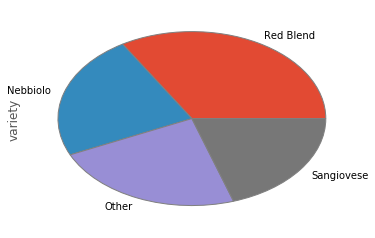

In [147]:
newitalianwines.variety.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

In [148]:
feature_cols = ['points', 'log_price', 'variety_label']
X = newitalianwines[feature_cols] 
y = newitalianwines.region_label

In [149]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [150]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6523551479783243


In [151]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.7882451021258858


In [152]:
feature_cols = ['log_price']
X = newitalianwines[feature_cols] 
y = newitalianwines.region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4414339308045019


In [153]:
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.3964151729887453


Using all the features, 'log price', 'points', and 'variety', the knn model was quite accurate for predicting region, at almost 79%.  However, the region labels may reflect unbalanced data:

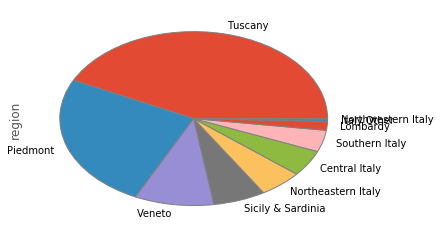

In [156]:
newitalianwines.region.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

Let's put the non-Piedmont or Tuscany wines in a separate "Other" category to make the data more balanced. 

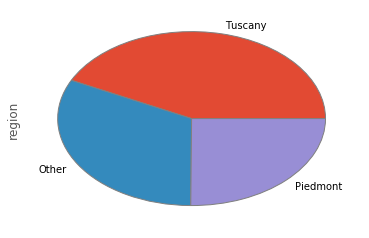

In [157]:
newitalianwines.loc[(newitalianwines['region'] != 'Piedmont') & (newitalianwines['region'] != 'Tuscany'), 'region'] = 'Other'
newitalianwines.region.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

The region category is much more balanced now.  Now let's perform knn and logistic regression again.

In [164]:
newitalianwines["region_label"] = newitalianwines["region"].astype('category')
newitalianwines["region_label"] = newitalianwines["region_label"].cat.codes
newitalianwines.region_label.unique()

array([0, 2, 1])

In [165]:
feature_cols = ['points', 'log_price', 'variety_label']
X = newitalianwines[feature_cols] 
y = newitalianwines.region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [169]:
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6932055022926219


In [170]:
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.8215923301375573


Balancing the data improved accuracy, with knn predicting 82% accuracy whether a given wine is from 'Tuscany', 'Piedmont', or 'Other', based on the 'point', 'log_price', and 'variety' features. 

To determine which of these features hold the most predictive power, let's create a few more models.

In [171]:
feature_cols = ['points', 'log_price']
X = newitalianwines[feature_cols] 
y = newitalianwines.region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.46894539391413087


In [172]:
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.43768236765318885


In [173]:
feature_cols = ['points', 'variety_label']
X = newitalianwines[feature_cols] 
y = newitalianwines.region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6052521884118383


In [174]:
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.8178407669862443


In [175]:
feature_cols = ['variety_label', 'log_price']
X = newitalianwines[feature_cols] 
y = newitalianwines.region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6965402250937891


In [176]:
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.8232596915381409


In [177]:
feature_cols = ['variety_label']
X = newitalianwines[feature_cols] 
y = newitalianwines.region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4739474781158816


In [178]:
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.8378491037932472


In [179]:
feature_cols = ['log_price']
X = newitalianwines[feature_cols] 
y = newitalianwines.region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4747811588161734


In [180]:
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.44268445185493954


In [181]:
feature_cols = ['points']
X = newitalianwines[feature_cols] 
y = newitalianwines.region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4456023343059608


In [182]:
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.3272196748645269


'Variety', by far, is most predictive of region.  'Points' and 'price' have a lower predictive accuracy, and this is also influenced by model choice, with knn being less accurate than logistic regression.

# California Wines

In [74]:
caliwines['sub_region'].value_counts()

Napa Valley                                     4475
Russian River Valley                            3090
California                                      2627
Paso Robles                                     2327
Sonoma Coast                                    1467
Sonoma County                                   1245
Carneros                                         999
Santa Barbara County                             994
Sta. Rita Hills                                  971
Dry Creek Valley                                 936
Santa Ynez Valley                                806
Santa Lucia Highlands                            802
Lodi                                             799
Alexander Valley                                 780
Central Coast                                    737
Santa Maria Valley                               701
Sonoma Valley                                    660
Anderson Valley                                  646
Santa Cruz Mountains                          

There are many sub-regions for California wines in the dataset, but many of them only appear a few times.  Thus, it makes the most sense to consider only the sub-regions that appear a significant number of times for analysis. 

In [75]:
calsubregions = caliwines['sub_region'].value_counts() > 500
calsubregions = calsubregions[calsubregions]
calsubregionslist = list(calsubregions.index)
modified_caliwines = caliwines[caliwines['sub_region'].isin(calsubregionslist)]

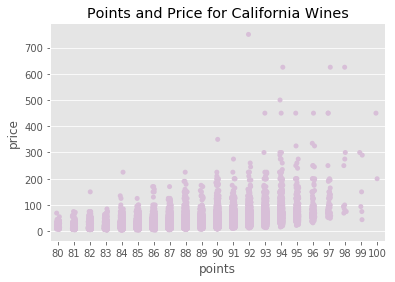

In [76]:
sns.stripplot(data=modified_caliwines, x='points', y='price', jitter = True, color = "thistle")

plt.title('Points and Price for California Wines')

The next step is to remove outliers-- data points with a z-score greater than 3.

In [77]:
standardized = modified_caliwines.groupby('points').transform(zscore)
outliers = (standardized['price'] > 3) | (standardized['price'] < -3)
modified_caliwines_outliers = modified_caliwines.loc[outliers]
common = modified_caliwines.merge(modified_caliwines_outliers,on=['index'])
newcaliwines = modified_caliwines[(~modified_caliwines.index.isin(common.index))]

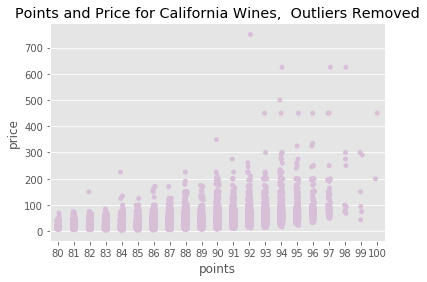

In [78]:
sns.stripplot(data=newcaliwines, x='points', y='price', jitter = True, color = "thistle")
plt.title('Points and Price for California Wines,  Outliers Removed')

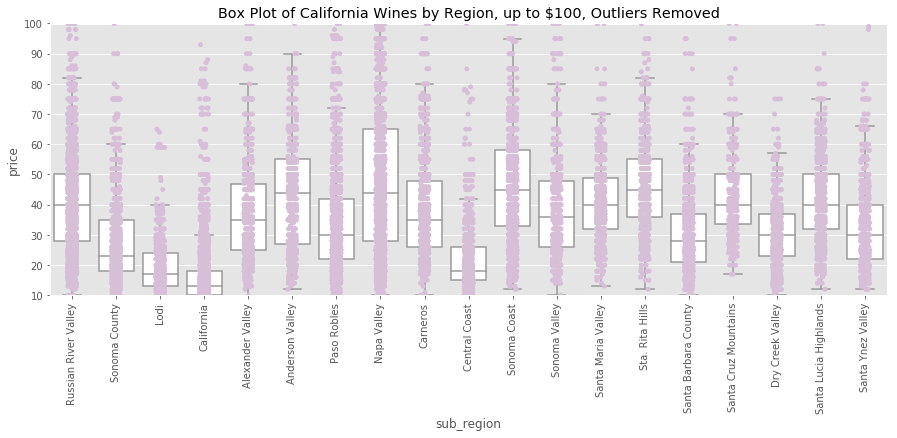

In [79]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='sub_region', y='price', data=newcaliwines, showfliers=False, color='white')
sns.stripplot(x='sub_region', y='price', data=newcaliwines, color="thistle", jitter = True)
plt.xticks(rotation=90)
plt.ylim(10, 100)
plt.title("Box Plot of California Wines by Region, up to $100, Outliers Removed")

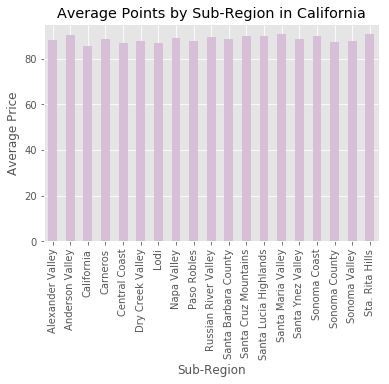

In [80]:
avg_points_per_sub_region = modified_caliwines.groupby('sub_region')['points'].mean()
avg_points_per_sub_region.plot(kind ='bar', color = 'thistle')
plt.title('Average Points by Sub-Region in California')
plt.ylabel('Average Price')
plt.xlabel('Sub-Region')

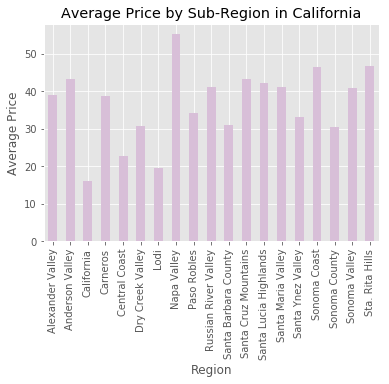

In [81]:
avg_price_per_sub_region = modified_caliwines.groupby('sub_region')['price'].mean()
avg_price_per_sub_region.plot(kind ='bar', color = 'thistle')
plt.title('Average Price by Sub-Region in California')
plt.ylabel('Average Price')
plt.xlabel('Region')

Even after removing outliers, **Napa Valley**, **Sonoma Coast**, and **Sta. Rita Hills** wines stand out as significantly higher priced than wines from other regions. 

Since **price** is an important feature for the wines, let's plot the distribution of this feature. 

(array([2.058e+03, 7.448e+03, 6.120e+03, 5.181e+03, 2.623e+03, 9.750e+02,
        4.870e+02, 2.460e+02, 6.000e+01, 1.340e+02, 5.600e+01, 6.900e+01,
        2.100e+01, 2.900e+01, 1.600e+01, 3.100e+01, 1.500e+01, 1.000e+00,
        8.000e+00, 3.000e+00, 5.000e+00, 2.000e+00, 5.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([  0.        ,  13.33333333,  26.66666667,  40.        ,
         53.33333333,  66.66666667,  80.        ,  93.33333333,
        106.66666667, 120.        , 133.33333333, 146.66666667,
        160.        , 173.33333333, 186.66666667, 200.        ,
        213.33333333, 226.66666667, 240.        , 253.33333333,
        266.66666667, 280.        , 293.33333333, 306.66666667,
        320.        , 333.33333333, 346.66666667, 360.        ,
        373.33333333, 386.66666667, 400.        ]),
 <a list of 30 Patch objects>)

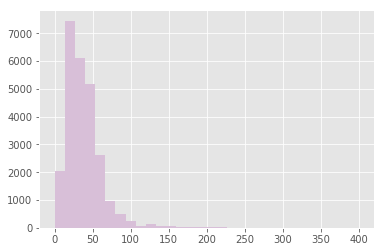

In [82]:
caprice = modified_caliwines['price']
plt.hist(caprice, range=(0,400), bins= 30, color = 'thistle')

Again, the data is highly skewed to the right.

The T-test and  Mann Whitney U Test are performed on wines from Napa Valley, Sonoma Coast and Sta. Rita Hills (which visualizations indicated were more expensive) and other regions in California.

In [83]:
napasonomastarita = modified_caliwines[(modified_caliwines['sub_region']=='Napa Valley') | (modified_caliwines['sub_region']=='Sonoma Coast') | (modified_caliwines['sub_region']=='Sta. Rita Hills')]
othercaliregions = modified_caliwines[(modified_caliwines['sub_region']!='Napa Valley') & (modified_caliwines['sub_region']!='Sonoma Coast') & (modified_caliwines['sub_region']!='Sta. Rita Hills')]
ttest_ind(napasonomastarita['price'], othercaliregions['price'])

Ttest_indResult(statistic=52.91161358334589, pvalue=0.0)

In [84]:
stats.mannwhitneyu(napasonomastarita['price'], othercaliregions['price'])

MannwhitneyuResult(statistic=37830193.0, pvalue=0.0)

Again, the low p-values indicate that the difference in averages is not coincidental.  Log normalization can be performed to make the **price** feature more normal.

In [85]:
newcaliwines['log_price'] = np.log(modified_caliwines['price'])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([0.000e+00, 0.000e+00, 4.000e+00, 1.020e+02, 1.597e+03, 4.457e+03,
        6.384e+03, 8.285e+03, 3.893e+03, 4.980e+02, 1.820e+02, 2.600e+01,
        1.100e+01, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <a list of 20 Patch objects>)

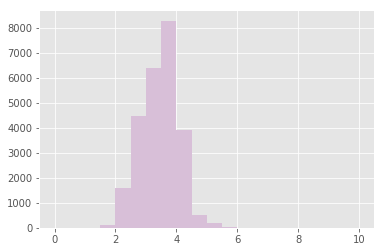

In [86]:
plt.hist(newcaliwines['log_price'], range=(0,10), bins= 20, color = 'thistle')

In [87]:
newcaliwines["sub_region_label"] = newcaliwines["sub_region"].astype('category')
newcaliwines["sub_region_label"] = newcaliwines["sub_region_label"].cat.codes
newcaliwines.sub_region.value_counts()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Napa Valley              4438
Russian River Valley     3073
California               2617
Paso Robles              2308
Sonoma Coast             1455
Sonoma County            1241
Carneros                  993
Santa Barbara County      989
Sta. Rita Hills           967
Dry Creek Valley          927
Santa Lucia Highlands     799
Santa Ynez Valley         798
Lodi                      798
Alexander Valley          772
Central Coast             733
Santa Maria Valley        692
Sonoma Valley             654
Anderson Valley           642
Santa Cruz Mountains      544
Name: sub_region, dtype: int64

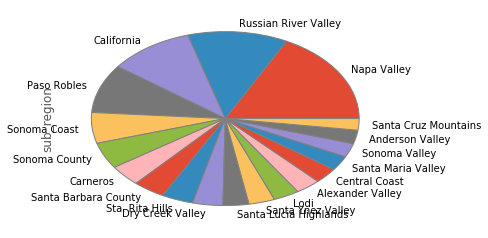

In [88]:
newcaliwines.sub_region.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

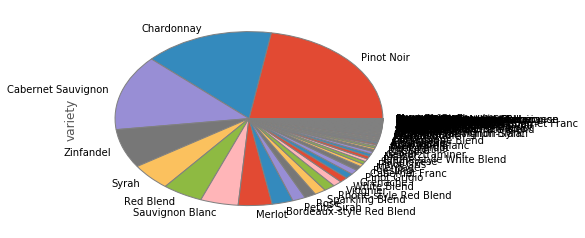

In [89]:
newcaliwines.variety.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

In [90]:
newcaliwines["variety_label"] = newcaliwines["variety"].astype('category')
newcaliwines["variety_label"] = newcaliwines["variety_label"].cat.codes

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Now, let's balance the **sub-region** and **variety** feature.  This is particularly crucial for **variety**.

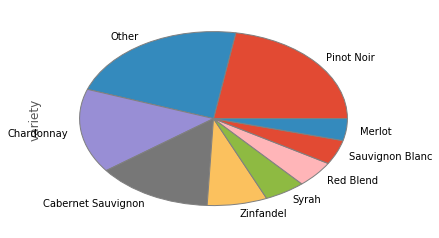

In [91]:
newcaliwines.loc[(newcaliwines['variety'] != 'Pinot Noir') & (newcaliwines['variety'] != 'Chardonnay') &(newcaliwines['variety'] != 'Cabernet Sauvignon')&(newcaliwines['variety'] != 'Zinfandel')&(newcaliwines['variety'] != 'Syrah')&(newcaliwines['variety'] != 'Red Blend')&(newcaliwines['variety'] != 'Sauvignon Blanc')&(newcaliwines['variety'] != 'Merlot'), 'variety'] = 'Other'
newcaliwines.variety.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

In [92]:
feature_cols = ['points', 'log_price', 'variety_label']
X = newcaliwines[feature_cols] 
y = newcaliwines.sub_region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [93]:
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.25943396226415094


In [94]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.32845911949685536


In [95]:
newcaliwines.sub_region.value_counts()

Napa Valley              4438
Russian River Valley     3073
California               2617
Paso Robles              2308
Sonoma Coast             1455
Sonoma County            1241
Carneros                  993
Santa Barbara County      989
Sta. Rita Hills           967
Dry Creek Valley          927
Santa Lucia Highlands     799
Santa Ynez Valley         798
Lodi                      798
Alexander Valley          772
Central Coast             733
Santa Maria Valley        692
Sonoma Valley             654
Anderson Valley           642
Santa Cruz Mountains      544
Name: sub_region, dtype: int64

In [96]:
len(newcaliwines.sub_region.value_counts())

19

25-30% accuracy is quite good given the fact that there at 19 labels -- Random prediction would have just over 5% accuracy for this many labels.  Nonetheless, we can enhance the predictive accuracy of the model by decreasing the number of sub-region labels. 

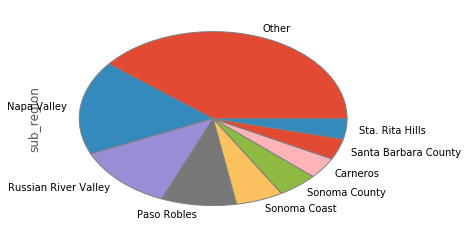

In [97]:
newcaliwines.loc[(newcaliwines['sub_region'] != 'Napa Valley') & (newcaliwines['sub_region'] != 'Russian River Valley') &(newcaliwines['sub_region'] != 'Paso Robles')&(newcaliwines['sub_region'] != 'Sonoma Coast')&(newcaliwines['sub_region'] != 'Sonoma County')&(newcaliwines['sub_region'] != 'Carneros')&(newcaliwines['sub_region'] != 'Santa Barbara County')&(newcaliwines['sub_region'] != 'Sta. Rita Hills'), 'sub_region'] = 'Other'
newcaliwines.sub_region.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

In [100]:
sub_regioncounts = newcaliwines.sub_region.value_counts()
count_class_0 = sub_regioncounts['Other']
count_class_1 = sub_regioncounts['Napa Valley']
print (count_class_0)
print (count_class_1)

other = newcaliwines[newcaliwines.sub_region == 'Other']
napa = newcaliwines[newcaliwines.sub_region == 'Napa Valley']
notnapaorother = newcaliwines[(newcaliwines.sub_region != 'Other') & (newcaliwines.sub_region != 'Napa Valley')]


other_under = other.sample(count_class_1)
newcaliwines = pd.concat([other_under, notnapaorother, napa], axis=0)

9460
4210


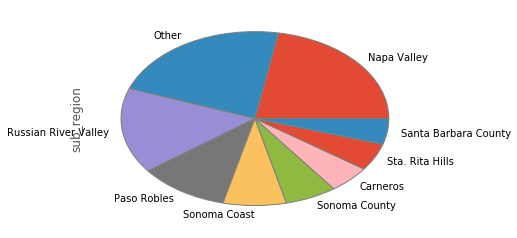

In [101]:
newcaliwines.sub_region.value_counts().plot(kind='pie', wedgeprops={"edgecolor":"grey",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})

In [102]:
feature_cols = ['points', 'log_price', 'variety_label']
X = newcaliwines[feature_cols] 
y = newcaliwines.sub_region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [103]:
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.28429926238145414


In [104]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.3561643835616438


This is a bit more accurate.  Visualizations indicated that there was a significant different in price between wines from Napa Valley, Sonoma Coast, and Sta. Rita Hills.  We can put these wines into one category and all of the other wines into another. 

In [114]:
def label_cal_region (row):
    if row['sub_region'] == 'Napa Valley' or row['sub_region'] == 'Sonoma Coast' or row['sub_region'] == 'Sta. Rita Hills':
        return 0
    else:
        return 1

newcaliwines['new_region_label'] = newcaliwines.apply(lambda row: label_cal_region(row), axis=1)

In [119]:
counts = newcaliwines.new_region_label.value_counts()
print('Napa, Sonoma, or Sta. Rita Hills Wines:', counts[0])
print('Other California Wines:', counts[1])
print('Proportion:', round(counts[0] / counts[1], 2), ': 1')

Napa, Sonoma, or Sta. Rita Hills Wines: 6616
Other California Wines: 12361
Proportion: 0.54 : 1


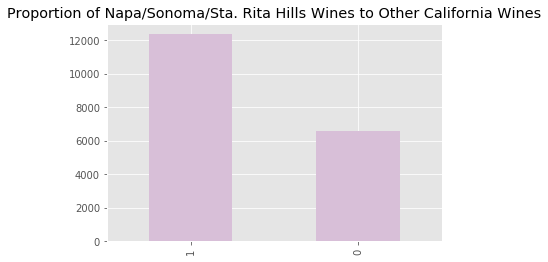

In [120]:
counts.plot(kind='bar', title='Proportion of Napa/Sonoma/Sta. Rita Hills Wines to Other California Wines', color='thistle')

In [121]:
count_class_0, count_class_1 = newcaliwines.new_region_label.value_counts()
df_class_napa_sonoma_rita_wines = newcaliwines[newcaliwines.new_region_label == 0]
df_class_other_cali_wines = newcaliwines[newcaliwines.new_region_label == 1]

Random over-sampling:
1    12361
0    12361
Name: new_region_label, dtype: int64


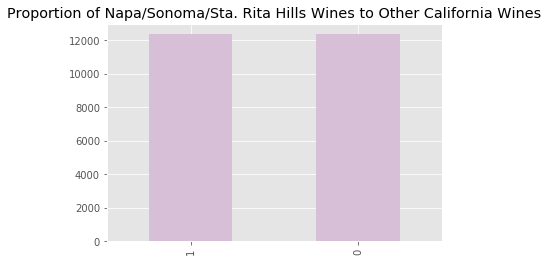

In [122]:
df_class_0_over = df_class_napa_sonoma_rita_wines.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_other_cali_wines, df_class_0_over], axis=0)

print('Random over-sampling:')
print(df_test_over.new_region_label.value_counts())

df_test_over.new_region_label.value_counts().plot(kind='bar', title='Proportion of Napa/Sonoma/Sta. Rita Hills Wines to Other California Wines', color='thistle');

In [125]:
feature_cols = ['points', 'log_price', 'variety_label']
X = df_test_over[feature_cols] 
y = df_test_over.new_region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [126]:
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6409966024915063


In [127]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.6898560103543117


Creating the 'new_region_label' feature and using it for y yielded a higher accuracy percentage.  We can now decide which feature individual feature has the most predictive power in this data.

In [128]:
feature_cols = ['points']
X = df_test_over[feature_cols] 
y = df_test_over.new_region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.5690017796473062
Accuracy: 0.52159844685326


In [129]:
feature_cols = ['log_price']
X = df_test_over[feature_cols] 
y = df_test_over.new_region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.6198026209351237
Accuracy: 0.5969907781912311


In [130]:
feature_cols = ['variety_label']
X = df_test_over[feature_cols] 
y = df_test_over.new_region_label
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print("Accuracy: " + str(knn.score(X_test, y_test)))

Accuracy: 0.5834007442161463
Accuracy: 0.5871218249474195


**'Variety'** and **'price'** are the most important features for prediction, and when both are features, the model has higher predictive accuracy. 

# Conclusion

....

Conclusion -- Price is associated with Points.  'Price' and 'Points are predictive for Region of origin with French, Italian, and Californian wines.  Include Pearson correlation coefficient info from stats notebook............

What is the association between price and points given?  First, let's examine visualizations of price and points data in the dataset.

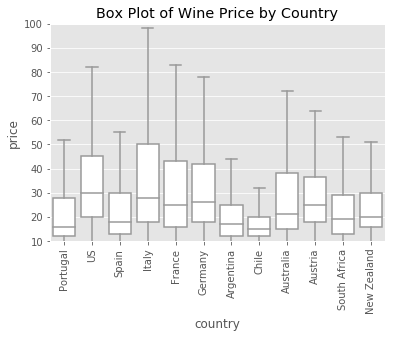

In [66]:
sns.boxplot(x='country', y='price', data=winedata, showfliers=False, color='white')
plt.ylim(10, 100)
plt.xticks(rotation=90)
plt.title("Box Plot of Wine Price by Country")

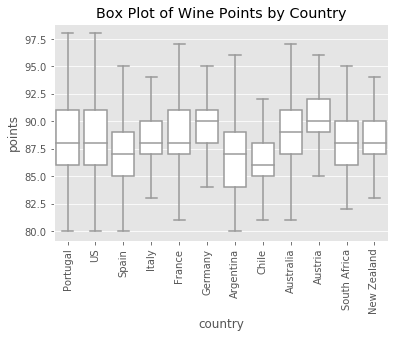

In [67]:
sns.boxplot(x='country', y='points', data=winedata, showfliers=False, color='white')
plt.xticks(rotation=90)
plt.title("Box Plot of Wine Points by Country")

Are the points given to wines in the dataset associated with price?  Calculating the Pearson correlation coefficient can indicate the positive relationship between points and price in the entire dataset.

In [69]:
all_data_corr_mat = np.corrcoef(winedata['points'], winedata['price'])
print (all_data_corr_mat[0,1])

0.4170139701452048


In [70]:
french_corr_mat = np.corrcoef(frenchwines['points'], frenchwines['price'])
print (french_corr_mat[0,1])


0.4058294023943131


In [71]:
italian_corr_mat = np.corrcoef(italianwines['points'], italianwines['price'])
print (italian_corr_mat[0,1])

0.5280726946460933


In [72]:
cali_corr_mat = np.corrcoef(caliwines['points'], caliwines['price'])
print (cali_corr_mat[0,1])

0.44274738612470926


The previous lines show that for wines from all of the subgroups, price was positively associated with points given by raters; for Italian wines, this relationship was somewhat more pronounced.

....